In [163]:
# !pip install -U pip wheel
# !pip install -q -r /Users/ryan/github/lltk/requirements.txt
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'/Users/ryan/github/prosodic')
sys.path.insert(0,'/Users/ryan/github/lltk')
from llmdh import *
from prosodic import Word
prosodic.USE_CACHE=False
import plotnine as p9
from sqlitedict import SqliteDict
p9.options.figure_size=11,8
import lltk

In [164]:
from lltk.model.classifier import *

In [328]:
df=pd.read_pickle('data.allpoems.pkl')
excl_prompts=[
    'Write an unryhmed poem in the style of Shakespeare\'s dramatic monologues.',
    'Write an ryhmed poem in the style of Shakespeare\'s sonnets.',
    'Write a poem in the style of e.e. cummings',
    # 'Write a poem in the style of Walt Whitman.',
    'Write a poem in the style of Wallace Stevens.',
    'Continue the following poem:\n\nTyping, typing, fingers on the keyboard\nThe keys crack and bend under sweat and weight,\n'
]
df=df[~df.prompt.isin(excl_prompts)]
df['fline']=df.poem.apply(lambda x: x.strip().split('\n')[0])
df=df.drop_duplicates('fline')
df=df[df.model.apply(lambda x: True if not x.startswith('b. ') else x.startswith('b. 1950'))]
df_human=df[df.model.str.startswith('b.')]
df_llm=df[~df.model.str.startswith('b.')]
df_llm.model.value_counts()
# # df=pd.DataFrame(df.values, columns=df.columns)
# # df = df.groupby('model').sample(100)
# # df['model']=df.model.apply(lambda x: 'Human' if x.startswith('b.') else 'LLM')
# df.model.value_counts()

n=100
df_llm_smpl = pd.concat(
    gdf.sample(n) if len(gdf)>n else gdf
    for g,gdf in df_llm.groupby('model')
)
df_llm_smpl.model.value_counts()
dfsmpl=pd.concat([df_human.sample(n=len(df_llm_smpl)*2).assign(model2='Human'), df_llm_smpl.assign(model2='LLM')]).sample(frac=1)
dfsmpl.model.value_counts()

model
b. 1950-2000                1260
gpt-4-turbo                  100
llama2-uncensored:7b         100
gemini-pro                   100
gpt-3.5-turbo                100
claude-3-opus-20240229        96
claude-3-sonnet-20240229      87
claude-3-haiku-20240307       47
Name: count, dtype: int64

In [329]:
# df=pd.read_pickle('data.figdf.allpoems.pkl')
# df=df[df.model.apply(lambda x: True if not x.startswith('b. ') else x.startswith('b. 1950'))]
# df['fline']=df.poem.apply(lambda x: x.strip().split('\n'))
# df=df.drop_duplicates('fline')
# df=pd.DataFrame(df.values, columns=df.columns)
# # df = df.groupby('model').sample(100)
# # df['model']=df.model.apply(lambda x: 'Human' if x.startswith('b.') else 'LLM')
# df.model.value_counts()

In [330]:
# fn='data.figdf.smpl.pkl'
# dfsmpl = df.groupby('model').sample(2000)
# dfsmpl.to_pickle(fn)
# dfsmpl=pd.read_pickle(fn)
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean(x):
    return '\n\n'.join(
        ' '.join(
            z for z in nltk.word_tokenize(y.strip())
            if z not in stop_words
            and len(z)>=4
        ) 
        for y in x.split('\n\n')
        if '\n' in y.strip()
    )

dfsmpl['poem']=dfsmpl['poem'].apply(clean)
# dfsmpl

In [331]:
import pandas as pd
from collections import Counter
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def top_n_words(strings, n=1000, index=None):
    # Tokenize and count words in all strings
    word_counts = Counter()
    for s in strings:
        words = re.findall(r'\b\w+\b', s.lower())  # Tokenizing and converting to lowercase
        words = [x for x in words if x not in stop_words]
        word_counts.update(words)
    
    # Identify the top n most frequent words
    top_words = [word for word, count in word_counts.most_common(n)]
    
    # Create a DataFrame to hold the count of top words in each string
    data = []
    for s in strings:
        words = re.findall(r'\b\w+\b', s.lower())
        count = Counter(words)
        row = {word: count[word] for word in top_words}
        data.append(row)
    
    df = pd.DataFrame(data, index=index) if index is not None else pd.DataFrame(data)
    # df.index = strings  # Setting the index to the original strings for reference
    return df.fillna(0).applymap(float)

In [332]:
df2=top_n_words(dfsmpl.poem, index=dfsmpl.index)
# df2

In [333]:
df2['model']=dfsmpl['model2']
# df2

In [334]:
model = Classifier(df2)
model.classify('model')

In [335]:
model.dfr.mean(numeric_only=True)

prob          0.501273
correct       0.973810
support    1260.000000
dtype: float64

In [336]:
pd.options.display.max_rows=100
model.dfc

,feat,coeff
11,back,-0.091389
135,look,-0.084182
45,water,-0.082943
190,half,-0.080977
61,white,-0.077257
...,...,...
92,whispers,0.123147
36,heart,0.129446
793,courage,0.131432
88,gentle,0.139052


In [337]:
dfsmpl[dfsmpl.poem.str.contains('blood')].model2.value_counts()

model2
Human    138
LLM        9
Name: count, dtype: int64

In [338]:
# df[df.poem.str.contains('whispers')].model.value_counts()

In [339]:
# pcaplot(df2.set_index('model'))

In [340]:
# model.plot_prcurve()
dfsmpl.poem

2613     quiet garden touched morning Distant laughter ...
13901    started telephone ringing ringing threw baby b...
33311    little walks behind blow picking stones field ...
1219     fields gold beneath summer Wildflowers dance g...
51855    hard year always raining first months approach...
                               ...                        
32426    come backwater towns cabin overrun creepers co...
45777    walks table walk table\n\nwalking table walk t...
1180     night dark veil gently lifts first rays sunlig...
561      Garden light withdrew— fingers cool mossy Tomb...
47740    moment world part Fleshless àgeless changeless...
Name: poem, Length: 1890, dtype: object

In [342]:
# !pip install bertopic
from bertopic import BERTopic

# Assuming `documents` is your list of strings
# documents = ["Your first document text goes here.", "Your second document text.", "And so on..."]

# Create a BERTopic model
topic_model = BERTopic(calculate_probabilities=True)

# Fit the model to your documents
topics, probabilities = topic_model.fit_transform(dfsmpl.poem)

# # You can then inspect the topics that were generated
for topic in set(topics):
    if topic != -1:  # -1 refers to all outliers and should typically not be printed
        print(f"Topic #{topic}: {topic_model.get_topic(topic)}")

Topic #0: [('black', 0.013814234424219357), ('sparrow', 0.013499445825356534), ('john', 0.012587548956678981), ('like', 0.012426068087732743), ('private', 0.012011620743093976), ('logbook', 0.011971099497766443), ('xxiii', 0.011971099497766443), ('press1992forbidden', 0.011971099497766443), ('1996', 0.011971099497766443), ('chan', 0.011971099497766443)]
Topic #1: [('like', 0.022163013853121607), ('could', 0.013782209321792437), ('face', 0.012616191878956934), ('time', 0.01249921615386686), ('door', 0.01242472754297314), ('eyes', 0.012074546052545737), ('back', 0.011624795964247035), ('father', 0.011395760386160596), ('room', 0.011118426715881188), ('still', 0.011099217191911698)]
Topic #2: [('nature', 0.0568126202183067), ('gentle', 0.0377435879909705), ('beauty', 0.03678466007383481), ('bloom', 0.036144106970563916), ('breeze', 0.03499910711203657), ('flowers', 0.03475465881039172), ('sweet', 0.03178382052059046), ('meadow', 0.029928167851629772), ('bright', 0.02894944560949862), ('pe

In [343]:
dfsmpl['topic']=topics
# dfsmpl['prob']=probabilities
topic_names = topic_model.get_topic_info()
df_probabilities = pd.DataFrame(probabilities)
df_probabilities = df_probabilities.drop(df_probabilities.columns[0], axis=1)
df_probabilities = df_probabilities.div(df_probabilities.sum(axis=1), axis=0)
topic_representations = {row['Topic']: row['Name'] for index, row in topic_names.iterrows() if row['Topic'] != -1}
df_probabilities.columns = [topic_representations.get(i, f"Topic_{i+1}") for i in range(len(df_probabilities.columns))]
df_probabilities.index = dfsmpl.model2
df_probabilities

,0_black_sparrow_john_like,1_like_could_face_time,2_nature_gentle_beauty_bloom,3_wind_nature_whispers_gentle,4_night_moon_stars_light,5_heart_wanderer_forest_nature,6_find_tapestry_life_soul,7_knight_courage_hero_with,8_catchment_like_water_salt,9_love_dreams_their_where,10_words_verse_rhyme_thoughts,11_charlie_jumping_carp_uncle,12_girl_back_city_summer,13_sing_your_every_vast,14_vast_world_open_endless,15_wind_whispering_dove_sees,16_squirrels_marks_pretends_stones,17_morning_world_nature_awakens,18_salt_bowl_mermaid_juice,19_allies_they_next_door
model2,,,,,,,,,,,,,,,,,,,,
LLM,0.046111,0.029701,0.042428,0.035646,0.162858,0.045886,0.026282,0.049147,0.034741,0.042019,0.046598,0.052698,0.044469,0.046410,0.056693,0.046085,0.033969,0.044925,0.064606,0.048729
Human,0.068038,0.027998,0.035006,0.034600,0.065888,0.041361,0.027963,0.056416,0.033403,0.041074,0.075795,0.067688,0.039846,0.038852,0.047389,0.050351,0.033612,0.055204,0.108447,0.051067
Human,0.051808,0.030010,0.037376,0.031996,0.048658,0.033170,0.020694,0.104129,0.025270,0.026520,0.068189,0.070636,0.029471,0.032932,0.076566,0.091317,0.034439,0.074368,0.059021,0.053428
LLM,0.018669,0.550821,0.038854,0.030437,0.021128,0.023430,0.016294,0.022748,0.018589,0.017147,0.017248,0.019269,0.021165,0.026587,0.031701,0.024388,0.041870,0.020482,0.017112,0.022061
Human,0.390192,0.015535,0.020829,0.020678,0.023287,0.023931,0.013739,0.035691,0.016627,0.019332,0.061630,0.067591,0.019182,0.019634,0.032868,0.031697,0.021641,0.033850,0.078824,0.053243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Human,0.065274,0.029274,0.037303,0.036006,0.074575,0.044612,0.029946,0.053766,0.036211,0.045040,0.067502,0.063796,0.043123,0.041647,0.048811,0.049006,0.034598,0.053082,0.095564,0.050866
Human,0.032473,0.057732,0.118245,0.051070,0.056229,0.053313,0.027575,0.038192,0.037478,0.036182,0.028785,0.035110,0.051306,0.077886,0.094836,0.038915,0.055182,0.031993,0.033265,0.044232
LLM,0.020702,0.032346,0.040692,0.117957,0.022854,0.037333,0.017760,0.020597,0.021647,0.021267,0.017398,0.023994,0.023980,0.030591,0.035459,0.021192,0.424121,0.017743,0.019098,0.033270


In [344]:
dfx=df_probabilities.reset_index().groupby('model2').mean().T
dfx['Human-LLM']=dfx['Human']-dfx['LLM']
dfx.sort_values('Human-LLM')

model2,Human,LLM,Human-LLM
1_like_could_face_time,0.026354,0.105289,-0.078935
5_heart_wanderer_forest_nature,0.038210,0.098064,-0.059855
6_find_tapestry_life_soul,0.020076,0.062374,-0.042298
3_wind_nature_whispers_gentle,0.033008,0.074829,-0.041821
2_nature_gentle_beauty_bloom,0.034258,0.075095,-0.040837
4_night_moon_stars_light,0.045747,0.080882,-0.035136
13_sing_your_every_vast,0.031220,0.064560,-0.033340
9_love_dreams_their_where,0.027958,0.058583,-0.030625
8_catchment_like_water_salt,0.026678,0.056113,-0.029435
16_squirrels_marks_pretends_stones,0.034665,0.063857,-0.029192


In [345]:
model = Classifier(df_probabilities.reset_index())
model.classify('model2')

In [346]:
model.dfc

,feat,coeff
18,17_morning_world_nature_awakens,-0.507245
11,10_words_verse_rhyme_thoughts,-0.447524
0,model2,-0.437706
10,9_love_dreams_their_where,-0.414966
19,18_salt_bowl_mermaid_juice,-0.354178
7,6_find_tapestry_life_soul,-0.347512
17,16_squirrels_marks_pretends_stones,-0.326892
15,14_vast_world_open_endless,-0.299243
14,13_sing_your_every_vast,-0.167366
8,7_knight_courage_hero_with,0.134835


In [347]:
dfsmpl[dfsmpl.topic==5].model.value_counts()

model
gpt-4-turbo                 17
gemini-pro                  12
b. 1950-2000                 8
claude-3-opus-20240229       5
claude-3-sonnet-20240229     3
Name: count, dtype: int64

In [348]:
import pandas as pd
from sklearn.decomposition import PCA
from plotnine import *


def pcaplot(df):
    # Assuming `df` is your DataFrame with documents as rows and word frequencies as columns.

    # Perform PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df)

    # Create a DataFrame with the principal components
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=df.index).query('-2<PC1<2 & -2<PC2<2')

    # Calculate loadings (the importance of each feature/word on the components)
    loadings = pd.DataFrame(data=pca.components_.T, columns=['PC1', 'PC2'], index=df.columns)
    loadings['PC1*PC2'] = loadings['PC1'] * loadings['PC2']
    n=2
    top_words = loadings.sort_values('PC1').index[:n].tolist()
    top_words += loadings.sort_values('PC1').index[-n:].tolist()
    top_words += loadings.sort_values('PC2').index[:n].tolist()
    top_words += loadings.sort_values('PC2').index[-n:].tolist()
    # top_words += loadings.sort_values('PC1*PC2').index[:n].tolist()
    # top_words += loadings.sort_values('PC1*PC2').index[-n:].tolist()

    # # Select the most discriminative words based on the loadings, e.g., highest absolute values
    # top_words = loadings.abs().nlargest(5, 'PC1').index.tolist()  # You can adjust the number here
    # top_words += loadings.abs().nlargest(5, 'PC2').index.tolist()  # You can adjust the number here

    # Now, create a plot with plotnine
    plot = (
        ggplot(p9.aes(color='model2'))
        + geom_point(data=pca_df.reset_index(), mapping=aes(x='PC1', y='PC2'), size=2, alpha=0.6)
        # Plot vectors for the most discriminant words
        + geom_segment(data=loadings.loc[top_words], mapping=aes(x=0, y=0, xend='PC1', yend='PC2'), color='red')
        + geom_text(data=loadings.loc[top_words], mapping=aes(x='PC1', y='PC2', label=top_words), color='red', size=8)
        + theme_minimal()
        + labs(title='PCA Plot with Most Discriminant Word Vectors')
    )
    return plot

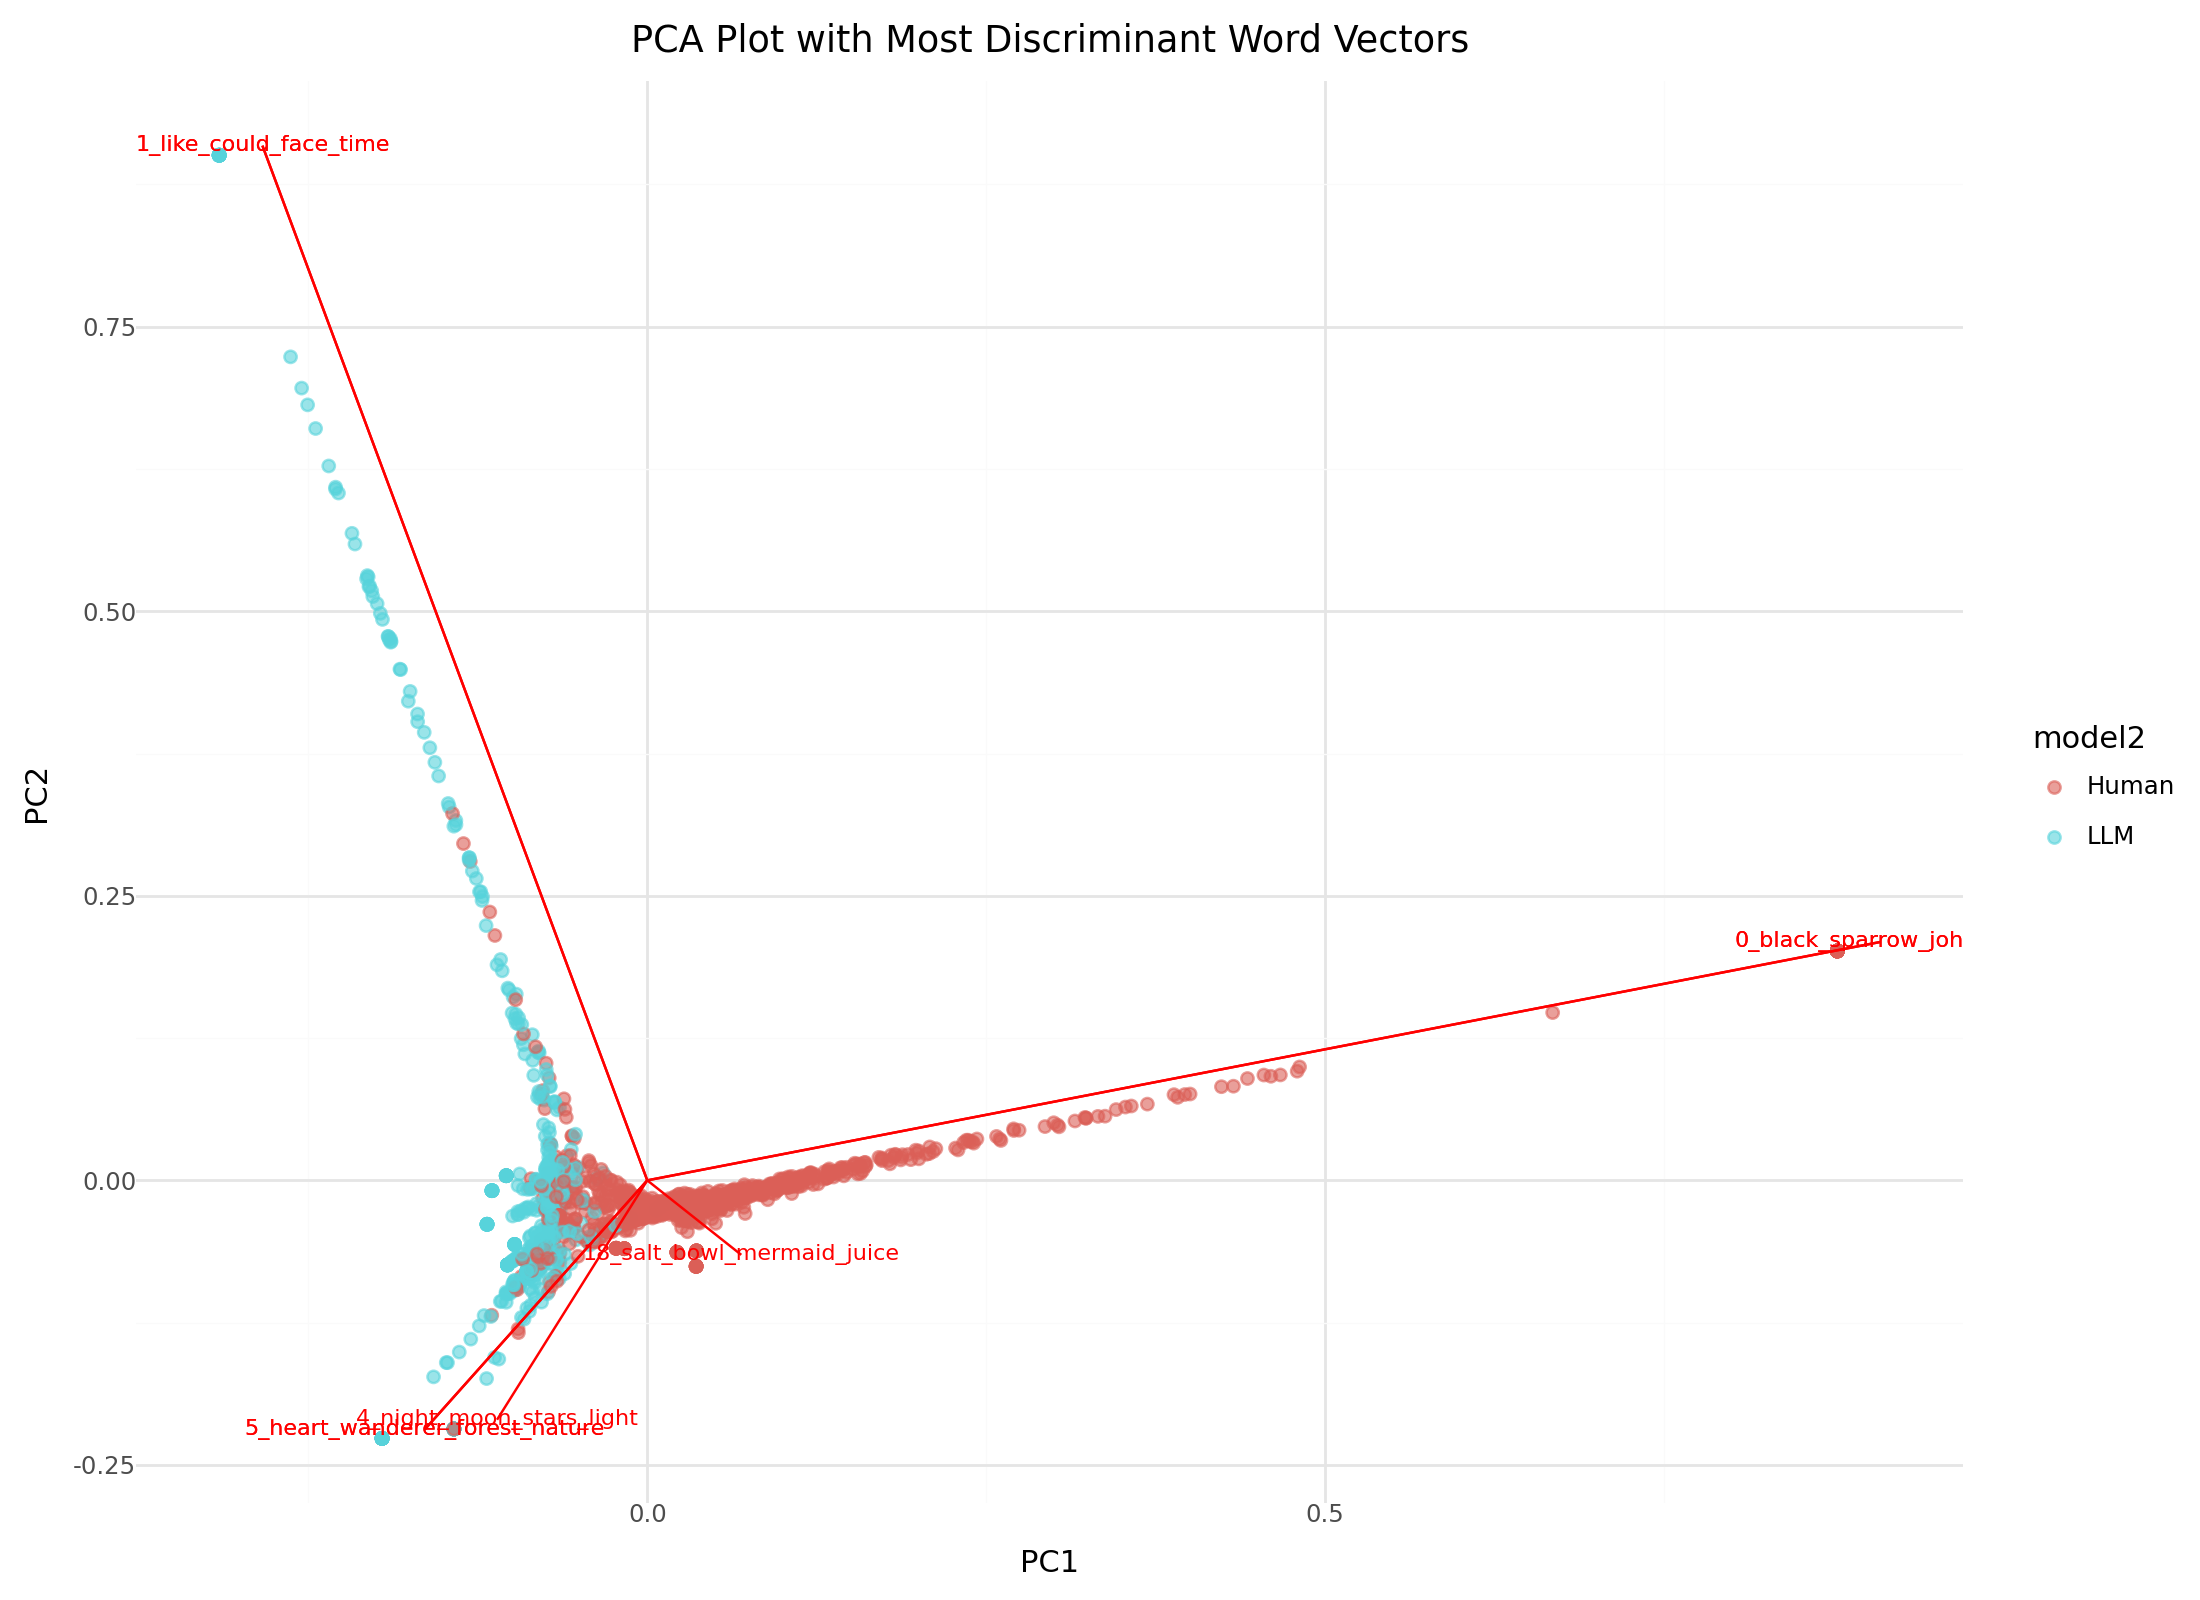

In [349]:
pcaplot(df_probabilities)